# Imports

## Librairies

In [2]:
import numpy as np
import pandas as pd
import warnings
from rpy2.rinterface import RRuntimeWarning
from collections import OrderedDict
import pandas as pd
import holoviews as hv
from bokeh.io import export_svgs
from six.moves import cStringIO as StringIO
from bokeh.plotting import figure, show, output_file

warnings.filterwarnings("ignore", category=RRuntimeWarning)
%load_ext rpy2.ipython

In [3]:
from matplotlib import pyplot as plt 
%matplotlib inline

## Global Variables

### Color Variables

In [58]:
univariate_plot_super_color = OrderedDict([
    ("urban fabric",   "#e69584"),
    ("functional area", "sandybrown"),
    ("infrastructure",  "#aeaeb8"  ),
    ("nature",     "darkseagreen"  ),
    ("no use",     "silver"  ),
])
univariate_plot_ses_color = OrderedDict([
    ("poor_ratio_mean", "#0d3362"),
    ("rich_ratio_mean", "#c64737"),
])
unicount_plot_ses_color = OrderedDict([
    ("poor", "#0d3362"),
    ("rich", "#c64737"),
])

### Class Variables

In [63]:
reference_dic_labels = {
    "agri_wetlnd":"Agricultural\nareas",
    "comr_indst":"Industrial/\ncommercial\nareas",
    "const/dmp":"Construction/\ndump sites",
    "green ua":"Green UA",
    "hd uf":"Dense\nDUF*",
    "isoltd":"Isolated\nstructures",
    "ld uf":"Low\ndens. DUF*",
    "leis fac.":"Sport/leisure\nfacilities",
    "md uf":"Medium\ndens. DUF*",
    "mtrways":"Motorways",
    "no use":" No use",
    "rlway":"Railway",
    "roads":"Roads",
    "vhd uf":"Continuous\nurban fabric",
    "vld uf":"Very Low\ndens. DUF*",
    "ntral areas":"Natural\nareas",
    "water":"Water",
    "osp/bch":"Open spaces/\nno vegetation",
}

class_super = pd.DataFrame([
    ("agri_wetlnd","functional area"),
    ("comr_indst","functional area"),
    ("const/dmp","functional area"),
    ("green ua","functional area"),
    ("hd uf","urban fabric"),
    ("isoltd","urban fabric"),
    ("ld uf","urban fabric"),
    ("leis fac.","functional area"),
    ("md uf","urban fabric"),
    ("mtrways","infrastructure"),
    ("no use","no use"),
    ("rlway","infrastructure"),
    ("roads","infrastructure"),
    ("vhd uf","urban fabric"),
    ("vld uf","urban fabric"),
    ("ntral areas","nature"),
    ("water","nature"),
    ("osp/bch","nature"),
],columns=["ITEM2012","super_class"])

ord_index = ['agri_wetlnd','green ua', 'comr_indst','leis fac.','const/dmp','no use', 'roads', 'rlway',
       'mtrways','water',"osp/bch",'ntral areas',  
       'isoltd', 'vld uf', 'ld uf', 'md uf', 'hd uf', 'vhd uf']

urban_classes = ['vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf']
re_format_ord_index = ['agri_wetlnd','green_ua', 'comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'rlway',
       'mtrways','water',"osp/bch",'ntral areas',  
       'isoltd', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf']

dic_order = OrderedDict([(v,k) for k,v in enumerate(ord_index)])

ord_class = ['agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads',
             'railway', 'motorways',"port",'water',"op_sp_beach",  
             'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf']

## Global Functions

### Renaming 

In [60]:
def chg_name(df):
    df.loc[df.ITEM2012=="motorways","ITEM2012"]="mtrways"
    df.loc[df.ITEM2012=="railway","ITEM2012"]="rlway"
    df.loc[df.ITEM2012=="natural areas","ITEM2012"]="ntral areas"
    df.loc[df.ITEM2012=="natural_areas","ITEM2012"]="ntral areas"
    df.loc[df.ITEM2012=="isoltd_rsdnt","ITEM2012"]="isoltd"
    df.loc[df.ITEM2012=="agri_wetland","ITEM2012"]="agri_wetlnd"
    df.loc[df.ITEM2012=="wetlands","ITEM2012"]="agri_wetlnd"
    df.loc[df.ITEM2012=="op_sp/beach","ITEM2012"]="osp/bch"
    df.loc[df.ITEM2012=="op_sp_beach","ITEM2012"]="osp/bch"
    return df

### Coactivating

In [61]:
fmt = lambda x:"_".join(x.split(" "))
def prepare_data(ses_data):
    cols = list(ses_data.columns)[1:]
    links = [tuple(map(fmt,
                       list(k.pair.replace("/","_").split("-"))),)+tuple(list(k.values)[1:] )for _,k in ses_data.iterrows() ]
    links_df = pd.DataFrame(links,columns=["source","target",]+cols)
    prep_links_df = links_df[links_df.low_ic_dist>0]
    return prep_links_df.dropna(how="any"),len(set(list(prep_links_df.source)+list(prep_links_df.target)))

def prepare_data_emp(ses_data):
    links = [(fmt(k.ua1.replace("/","_")),fmt(k.ua2.replace("/","_")),k.r1,k.r2,k.dist) for _,k in ses_data.iterrows() ]
    links_df = pd.DataFrame(links,columns=["source","target","r1","r2","med_dist"])
    return links_df.dropna(how="any"),len(set(list(links_df.source)+list(links_df.target)))

def unicount_pre_rad(mic):
    return (mic**.45)

def unicount_rad(mic,a):
    return (a*unicount_pre_rad(mic))

def univariate_rad(mic,a,b):
    return a *univariate_pre_rad((mic))  + b

def prepare_plot(prep_coact,nb=20):
    pre_a=prep_coact[["source","target","emp_a"]]
    pre_a.columns=["object","neighbour","med"]
    pre_b=prep_coact[["target","source","emp_b"]]
    pre_b.columns=["object","neighbour","med"]
    test = pd.concat([pre_a,pre_b],sort=False,axis=0)
    test=test[[("uf" in x ) for x,y in test[["object","neighbour"]].values]]#prep_poor_coinh_nice.reset_index(drop=True)#.drop("order",axis=1)
    #test=test[test.med>np.percentile(test.med,75)]
    test = test[(test.object!="airports")&(test.neighbour!="airports")][["neighbour","object","med"]]
    test=test.sort_values("med").tail(nb)
    n = len(set(test.object.tolist()).union(set(test.neighbour.tolist())))
    return test,n

def prepare_plot_emp(prep_emp_coact,nb=20):
    pre_a=prep_emp_coact[["source","target","r1"]]
    pre_a.columns=["object","neighbour","med"]
    pre_b=prep_emp_coact[["target","source","r2"]]
    pre_b.columns=["object","neighbour","med"]
    test = pd.concat([pre_a,pre_b],sort=False,axis=0)
    test=test[[("uf" in x ) for x,y in test[["object","neighbour"]].values]]#prep_poor_coinh_nice.reset_index(drop=True)#.drop("order",axis=1)
    #test=test[test.med>np.percentile(test.med,75)]
    test = test[(test.object!="airports")&(test.neighbour!="airports")][["neighbour","object","med"]]
    test=test.sort_values("med").tail(nb)
    n = len(set(test.object.tolist()).union(set(test.neighbour.tolist())))
    return test,n

stand_pair_in = lambda x : "-".join(np.sort(x.lower().split("-")).tolist())
stand_pair = lambda x : [stand_pair_in(y) for y in x]

def final_formatting(plot_df):
    ord_class_fun={k:(i+1) for i,k in enumerate(ord_class)}
    ord_fun = lambda x:ord_class_fun[x]
    final_coact = plot_df.copy()
    final_coact["neighbour"] = list(map(ord_fun,final_coact["neighbour"]))
    final_coact["object"] = list(map(ord_fun,final_coact["object"]))
    return final_coact

def filling_formatting(plot_df):
    filled_coact = plot_df.copy()
    for k in set(ord_class)-set(filled_coact.neighbour).union(set(filled_coact.object)):
        filled_coact=filled_coact.append(pd.DataFrame([(k,"ld_uf",1e-1)],columns=["neighbour","object","med"]))
    filled_coact.reset_index(drop=True,inplace=True)
    return filled_coact

In [8]:
%%R
#library(patchwork)
library(hrbrthemes)
library(circlize)
library(chorddiag)  #devtools::install_github("mattflor/chorddiag")
library("ggplot2")
library("ggsci")
# Libraries
library(tidyverse)
library(viridis)
library(RColorBrewer)

plot_filled_chords <- function(prep_links_df,ses,nb,city,full_cmap=FALSE) {
    pdf(paste(c("/Users/jacobolevyabitbol/Desktop/mk_meeting/CITIES/filled/",city,"_",ses,"_filled_coact.pdf"),
              collapse="")) 
    circos.clear()
    circos.par(start.degree = 90,
               track.margin = c(-0.1, 0.1), points.overflow.warning = FALSE)
    par(mar = rep(0, 4))
    ord <-c('agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
            'motorways',"port",'water',"op_sp_beach",  
            'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf')
    col_ord<-rev(colorRampPalette(brewer.pal(name="Spectral", n = 11))(length(ord)))
    names(col_ord) <- ord
    empty<-prep_links_df[prep_links_df$med == 0.1,]$neighbour
    for (sector in ord){
        if (sector %in% empty){
            col_ord[sector]="#00000000"
        }else{
            col_ord[sector]=paste(col_ord[sector],"CC",sep="")
        }
    }
    chordDiagram(
      x = prep_links_df, 
      transparency = 0.25,
      directional = 1,
      order = ord,
      grid.col = array(col_ord),
      annotationTrackHeight = c(0.1, 1),
      annotationTrack ="grid",
      link.sort = TRUE, 
      direction.type = c("arrows", "diffHeight"), 
      link.arr.type = "big.arrow", 
      link.largest.ontop = TRUE)
    
    # Add text and axis
    circos.trackPlotRegion(
      track.index = 1, 
      bg.border = NA, 
      panel.fun = function(x, y) {
        xlim = get.cell.meta.data("xlim")
        ylim = get.cell.meta.data("ylim")
        sector.index = get.cell.meta.data("sector.index")
        sn = CELL_META$sector.numeric.index
        i_state = as.numeric(gsub("(C|R)_", "", sn))
        if(abs(CELL_META$cell.start.degree - CELL_META$cell.end.degree) > 1) {
            circos.text(CELL_META$xcenter, CELL_META$ycenter, sn, col = "black", 
                        font = 2, cex = 2, adj = c(0.5, 0.5), niceFacing = TRUE)
            circos.text(CELL_META$xcenter, CELL_META$ycenter, sn, col = "white", 
                        font = 2, cex = 2, adj = c(0.5, 0.5), niceFacing = TRUE)
            circos.axis(h = "top", major.at = seq(from = 0, to = xlim[2],
                                   by =ifelse(test = xlim[2]>10,yes = 8,
                                    no=ifelse(test = xlim[2]>4,yes = 4,
                                        no=ifelse(test = xlim[2]>2,yes = 2,no=1)))), 
              minor.ticks = 5, major.tick.percentage = 1,labels.niceFacing = TRUE,labels.cex = 1.3)
         } 
    }
    )
}
darken <- function(color, factor=1.03){
  col <- col2rgb(color)
  col <- col/factor
  col <- rgb(t(col), maxColorValue=255)
  col
}
plot_chords <- function(prep_links_df,ses,nb,city,full_cmap=FALSE) {
    # Load dataset from github
    pdf(paste(c("/Users/jacobolevyabitbol/Desktop/mk_meeting/CITIES/full/",city,"_",ses,"_coact.pdf"),collapse="")) 
    # parameters
    circos.clear()
    circos.par(start.degree = 90,
               track.margin = c(-0.1, 0.1), points.overflow.warning = FALSE)
    par(mar = rep(0, 4))
    ord <-c('agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
        'motorways',"port",'water',"op_sp_beach",  
        'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf')
    ord<-1:length(ord)
    #col_ord<-rev(colorRampPalette(inferno(nb))(nb))
    #col_ord<-colorRampPalette(unlist(wes_palettes["Darjeeling1"]))(nb)
    col_ord<-unlist(map(rev(colorRampPalette(brewer.pal(name="Spectral", n = 11)[1:11])(nb)),darken))
    #col_ord<-rev(colorRampPalette(brewer.pal(name="Spectral", n = 11)[1:11])(nb))
    # Base plot
    chordDiagram(
      x = prep_links_df, 
      transparency = 0.25,
      directional = 1,
      order = ord,
      grid.col = array(col_ord),
      annotationTrackHeight = c(0.1, 1),
      annotationTrack ="grid",
      link.sort = TRUE, 
      direction.type = c("arrows", "diffHeight"), 
      link.arr.type = "big.arrow", 
      link.largest.ontop = TRUE)

    # Add text and axis
    circos.trackPlotRegion(
      track.index = 1, 
      bg.border = NA, 
      panel.fun = function(x, y) {
        xlim = get.cell.meta.data("xlim")
        ylim = get.cell.meta.data("ylim")
        sector.index = get.cell.meta.data("sector.index")
        sn = CELL_META$sector.numeric.index
        i_state = as.numeric(gsub("(C|R)_", "", sn))
        if(abs(CELL_META$cell.start.degree - CELL_META$cell.end.degree) > 1) {
            #circos.text(CELL_META$xcenter, CELL_META$ycenter, paste("",sector.index,sep=""), col = "black", 
            #            font = 1, cex = 1.6, adj = c(0.5, 0.5), niceFacing = TRUE)
             if (FALSE){# (abs(CELL_META$cell.start.degree - CELL_META$cell.end.degree) > 10){
                circos.text(CELL_META$xcenter, CELL_META$ycenter, paste("",sector.index,sep=""), col = "white", 
                        font = 2, cex = 2, adj = c(0.5, 0.5), niceFacing = TRUE)
                circos.axis(h = "top", col="black",labels.col="black",
                        major.at = seq(from = 0, to = xlim[2]+10, 
                            by = ifelse(test = xlim[2]>20,yes = 8,
                            no=ifelse(test = xlim[2]>10,yes = 5,
                            no=ifelse(test = xlim[2]>6,yes = 3,
                            no=ifelse(test = xlim[2]>2,yes = 2,
                            no =ifelse(test = xlim[2]>1,yes = 1,
                            no=ifelse(test = xlim[2]>0.5,yes = 0.5,
                            no=ifelse(test = xlim[2]>0.4,yes = 0.4,no=0.2)))))))),
                            minor.ticks = ifelse(test = xlim[2]>20,yes = 20,
                            no=ifelse(test = xlim[2]>10,yes = 10,no=5))
                            , major.tick.percentage = 10,labels.niceFacing = TRUE,labels.cex = 1.3)
            }else {
                 circos.text(CELL_META$xcenter, CELL_META$ycenter, paste("",sector.index,sep=""), col = "white", 
                        font = 2, cex = 2, adj = c(0.5, 0.5), niceFacing = TRUE)
                 circos.axis(h = "top", col="black",labels.col="black",
                        major.at = seq(from = 0, to = xlim[2]+10, 
                            by = ifelse(test = xlim[2]>20,yes = 8,
                            no=ifelse(test = xlim[2]>10,yes = 5,
                            no=ifelse(test = xlim[2]>6,yes = 3,
                            no=ifelse(test = xlim[2]>2,yes = 2,
                            no =ifelse(test = xlim[2]>1,yes = 1, no=1 )))))),
                            minor.ticks = ifelse(test = xlim[2]>20,yes = 20,
                            no=ifelse(test = xlim[2]>10,yes = 10,no=5))
                            , major.tick.percentage = 10,labels.niceFacing = TRUE,labels.cex = 1.3)
            }
        } 
      }
    )
}

R[write to console]: NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

R[write to console]:       Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

R[write to console]:       if Arial Narrow is not on your system, please see http://bit.ly/arialnarrow

R[write to console]: ========================================
circlize version 0.4.6
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: http://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization 
  in R. Bioinformatics 2014.


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.3
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  2.1.3     ✔ forcats 0.3.0

R[write to co

# Global Inequality Plots

In [6]:
ineq_dir="../../Downloads/WID_Data_Metadata/"
ineq_data= pd.read_csv(ineq_dir + "WID_Data_16082019-102552.csv",skiprows=range(1),sep=";")
ineq_data.columns = ["perc","year","europe","north_am","china","india"]
fmt_ineq_data = []
for _,k in ineq_data.iterrows():
    perc,year,europe,north_am,china,india = k.values
    if perc == "p99p100":
        perc = "Top 1 %"
    else:
        perc = "Bottom 50 %"
    fmt_ineq_data.append((perc,year,100*europe,"Europe"))
    fmt_ineq_data.append((perc,year,100*north_am,"United States\n and Canada"))
    fmt_ineq_data.append((perc,year,100*china,"China"))
    fmt_ineq_data.append((perc,year,100*india,"India"))

df_fmt_ineq_data = pd.DataFrame(fmt_ineq_data,columns=["Percentile","year","value","region"])

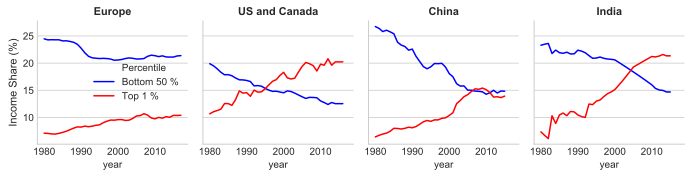

In [7]:
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn-whitegrid')

# Plot the lines on two facets
g= sns.relplot(x="year", y="value",palette=["b", "r"], 
            hue="Percentile",col="region",hue_order=["Bottom 50 %","Top 1 %"],
            height=2.7, aspect=.9, facet_kws=dict(sharex=True,sharey=True,legend_out=False),
            kind="line", legend="brief", data=df_fmt_ineq_data);
g.axes[0][0].set_ylabel("Income Share (%)",fontsize=11);
g.axes[0][0].set_title("Europe",fontweight='bold',fontsize=11,);
g.axes[0][1].set_title("US and Canada",fontweight='bold',fontsize=11,);
g.axes[0][2].set_title("China",fontweight='bold',fontsize=11,);
g.axes[0][3].set_title("India",fontweight='bold',fontsize=11,);

#g._legend._legend_box.align = "left"  # or left, or center
#g._legend.set_bbox_to_anchor([.2, .46])  # coordinates of lower left of bounding box

for d in g.axes.flat:
    d.xaxis.grid(False) 
g.savefig("/Users/jacobolevyabitbol/Desktop/inequality.pdf")

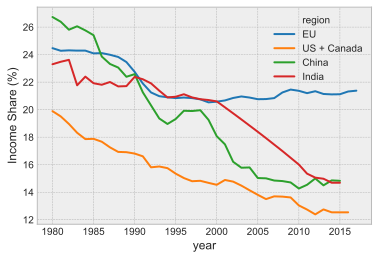

In [61]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('bmh')


# Plot the lines on two facets
g= sns.lineplot(x="year", y="value",palette="tab10",#hue=["b", "r","green","yellow"], 
            hue="region",#hue_order=["Bottom 50 %","Top 1 %"],
            data=df_fmt_ineq_data[df_fmt_ineq_data.Percentile=="Bottom 50 %"]);
g.axes.set_ylabel("Income Share (%)");

#g._legend._legend_box.align = "left"  # or left, or center
#g._legend.set_bbox_to_anchor([.2, .46])  # coordinates of lower left of bounding box

#
#g.savefig("/Users/jacobolevyabitbol/Desktop/inequality.pdf")

# Univariate Plots

## Activation Statistics

### Variable Log Scale 

In [4]:
# lille alpha 0
# marseille alpha 0.5
def univariate_bokeh_bursin_plot(ord_uni_ua_poor,ord_uni_ua_rich,city,univariate_pre_rad,err_scale = False):
    width,height,inner_radius,outer_radius,outest_radius = (800, 800, 80, 300 - 10, 343 - 10)
    cols = ["ITEM2012","poor_ratio_mean","poor_ratio_stderr","rich_ratio_mean","rich_ratio_stderr"]
    df_plot = pd.merge(pd.merge(ord_uni_ua_poor,ord_uni_ua_rich)[cols ].set_index("ITEM2012").reindex(ord_index)\
                       .reset_index(),class_super)
    if err_scale:
        min_val = np.nanmin(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values -\
                            df_plot[["poor_ratio_stderr","rich_ratio_stderr"]].values )
        max_val = np.nanmax(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values -\
                            df_plot[["poor_ratio_stderr","rich_ratio_stderr"]].values )
    else:
        min_val = np.nanmin(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values)
        max_val = np.nanmax(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values)
    labels = np.array([0.5,1,2.5,5])
    #
    minr,maxr = univariate_pre_rad(min_val), univariate_pre_rad(max_val)
    print(minr,maxr)
    big_angle = 2.0 * np.pi / (len(df_plot)+1)
    small_angle = big_angle / 3
    #
    angles = np.pi/2 - big_angle/2 - df_plot.index.to_series()*big_angle
    colors = [univariate_plot_super_color[sc] for sc in df_plot.super_class]
    #
    a = (outer_radius - inner_radius) / (maxr - minr)
    b = inner_radius + a * maxr
    p = figure(plot_width=width, plot_height=height, 
               title="{} Activations Ratio".format(city),x_axis_type=None, y_axis_type=None,
               x_range=(-420, 420), y_range=(-420, 420),
               min_border=0, outline_line_color="black",background_fill_color="#f0e1d2")
    #
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #
    # annular wedges
    p.annular_wedge( 0, 0, inner_radius, outest_radius, -big_angle+angles, angles, color=colors)
    # circular axes and lables
    radii = univariate_rad(labels,a,b)
    p.circle(0, 0, radius=radii, fill_color=None, line_color="white",)
    p.circle(0, 0, radius=univariate_rad(1,a,b), fill_color=None, line_color="yellow",line_width=2)
    p.text(0, radii, [str(r) for r in labels], text_font_size="12pt", text_align="center", text_baseline="middle")
    #
    # radial axes
    p.annular_wedge(0, 0,inner_radius-10,outest_radius+10,-big_angle+angles,-big_angle+angles,
                    color="black",line_width=2)

    # small wedges
    p.annular_wedge(0, 0, inner_radius,univariate_rad(df_plot.poor_ratio_mean,a,b),
                    -big_angle+angles+1.5*small_angle, -big_angle+angles+2.5*small_angle,
                    color=univariate_plot_ses_color['poor_ratio_mean'])
    p.annular_wedge(0, 0,
                    univariate_rad(df_plot.poor_ratio_mean-df_plot.poor_ratio_stderr,a,b),
                    univariate_rad(df_plot.poor_ratio_mean+df_plot.poor_ratio_stderr,a,b),
                    -big_angle+angles+2*small_angle, -big_angle+angles+2*small_angle,
                    color="black")
    p.annular_wedge(0, 0, inner_radius,univariate_rad(df_plot.rich_ratio_mean,a,b),
                    -big_angle+angles+0.5*small_angle, -big_angle+angles+1.5*small_angle,
                    color=univariate_plot_ses_color['rich_ratio_mean'])
    p.annular_wedge(0, 0,
                    univariate_rad(df_plot.rich_ratio_mean-df_plot.rich_ratio_stderr,a,b),
                    univariate_rad(df_plot.rich_ratio_mean+df_plot.rich_ratio_stderr,a,b),
                    -big_angle+angles+1*small_angle, -big_angle+angles+1*small_angle,
                    color="black")

    # ua labels
    ang_off=39
    r_off = 50
    xr = (outer_radius+r_off)*np.cos(np.array(-big_angle/2 + angles+np.pi/ang_off))
    yr = (outer_radius+r_off)*np.sin(np.array(-big_angle/2 + angles+np.pi/ang_off))
    label_angle=np.array(-big_angle/2+angles+np.pi/ang_off)
    label_angle[label_angle < -np.pi/2] += np.pi # easier to read labels on the left side
    p.text(xr, yr,df_plot.ITEM2012,angle=label_angle,text_font_size="13pt",text_align="center",text_baseline="middle")

    p.rect([-40,-40], [18, -18], width=30, height=13,color=list(univariate_plot_ses_color.values()))
    p.text([-15, -15], [18, -18],text=[" "," "],text_font_size="11pt",text_font_style="bold", text_align="left",
           text_baseline="middle")
    output_file("{}_act_ratios.html".format(city), title="{} Activations Ratio".format(city));
    show(p)

In [24]:
city = "Marseille"
def univariate_pre_rad(mic,alpha=.5):
    return alpha+np.log(mic)
ord_uni_ua_poor_marseille=pd.read_csv("./plot_data/{}/{}_poor.csv".format(city,city.lower()))
ord_uni_ua_rich_marseille=pd.read_csv("./plot_data/{}/{}_rich.csv".format(city,city.lower()))
univariate_bokeh_bursin_plot(ord_uni_ua_poor_marseille,ord_uni_ua_rich_marseille,city,univariate_pre_rad)

-1.4157951296774411 1.7621980136423607


In [25]:
city = "Lyon"
def univariate_pre_rad(mic,alpha=0.18):
    return alpha+np.log(mic)
ord_uni_ua_poor_lyon=pd.read_csv("./plot_data/{}/{}_poor.csv".format(city,city.lower()))
ord_uni_ua_rich_lyon=pd.read_csv("./plot_data/{}/{}_rich.csv".format(city,city.lower()))
univariate_bokeh_bursin_plot(ord_uni_ua_poor_lyon,ord_uni_ua_rich_lyon,city,univariate_pre_rad)

-1.2063588233885538 1.521695808402538


In [26]:
city = "Nice"
def univariate_pre_rad(mic):
    return .24+np.log((mic))

ord_uni_ua_poor_nice=pd.read_csv("./plot_data/{}/{}_poor.csv".format(city,city.lower()))
ord_uni_ua_rich_nice=pd.read_csv("./plot_data/{}/{}_rich.csv".format(city,city.lower()))
univariate_bokeh_bursin_plot(ord_uni_ua_poor_nice,ord_uni_ua_rich_nice,city,univariate_pre_rad,err_scale=True)

-1.3168822935225275 1.1564325277628973


In [27]:
city = "Lille"
def univariate_pre_rad(mic,alpha=0):
    return alpha+np.log(mic)
ord_uni_ua_poor_lille=pd.read_csv("./plot_data/{}/poor_{}.csv".format(city,city.lower()))
ord_uni_ua_rich_lille=pd.read_csv("./plot_data/{}/rich_{}.csv".format(city,city.lower()))
univariate_bokeh_bursin_plot(ord_uni_ua_poor_lille,ord_uni_ua_rich_lille,"Lille",univariate_pre_rad)

-1.0554162841375079 1.5670795436601397


Maybe its best to cap it all at 2 ?

### Capped at Value

In [8]:
from bokeh.util.compiler import TypeScript

TS_CODE = """
import * as p from "core/properties"
import {Label, LabelView} from "models/annotations/label"
declare const katex: any

export class LatexLabelView extends LabelView {
  model: LatexLabel

  render(): void {
    //--- Start of copied section from ``Label.render`` implementation

    // Here because AngleSpec does units tranform and label doesn't support specs
    let angle: number
    switch (this.model.angle_units) {
      case "rad": {
        angle = -this.model.angle
        break
      }
      case "deg": {
        angle = (-this.model.angle * Math.PI) / 180.0
        break
      }
      default:
        throw new Error("unreachable code")
    }

    const panel = this.panel != null ? this.panel : this.plot_view.frame

    const xscale = this.plot_view.frame.xscales[this.model.x_range_name]
    const yscale = this.plot_view.frame.yscales[this.model.y_range_name]

    let sx = this.model.x_units == "data" ? xscale.compute(this.model.x) : panel.xview.compute(this.model.x)
    let sy = this.model.y_units == "data" ? yscale.compute(this.model.y) : panel.yview.compute(this.model.y)

    sx += this.model.x_offset
    sy -= this.model.y_offset

    //--- End of copied section from ``Label.render`` implementation
    // Must render as superpositioned div (not on canvas) so that KaTextl
    // css can properly style the text
    this._css_text(this.plot_view.canvas_view.ctx, "", sx, sy, angle)

    // ``katex`` is loaded into the global window at runtime
    // katex.renderToString returns a html ``span`` element
    katex.render(this.model.text, this.el, {displayMode: true})
  }
}

export namespace LatexLabel {
  export type Attrs = p.AttrsOf<Props>

  export type Props = Label.Props
}

export interface LatexLabel extends LatexLabel.Attrs {}

export class LatexLabel extends Label {
  properties: LatexLabel.Props

  constructor(attrs?: Partial<LatexLabel.Attrs>) {
    super(attrs)
  }

  static initClass() {
    this.prototype.default_view = LatexLabelView
  }
}
LatexLabel.initClass()
"""
from bokeh.models import Label

class LatexLabel(Label):
    """A subclass of the Bokeh built-in `Label` that supports rendering
    LaTex using the KaTex typesetting library.

    Only the render method of LabelView is overloaded to perform the
    text -> latex (via katex) conversion. Note: ``render_mode="canvas``
    isn't supported and certain DOM manipulation happens in the Label
    superclass implementation that requires explicitly setting
    `render_mode='css'`).
    """
    __javascript__ = ["https://cdn.jsdelivr.net/npm/katex@0.11.1/dist/katex.js"]
    __css__ = ["https://cdn.jsdelivr.net/npm/katex@0.11.1/dist/katex.css"]
    __implementation__ = TypeScript(TS_CODE)


In [9]:
from IPython.display import SVG, HTML
import bokeh
from bokeh.io import export_svgs
from bokeh.io.export import get_screenshot_as_png

# lille alpha 0
# marseille alpha 0.5poor_ratio_stderr
def univariate_bokeh_bursin_plot(ord_uni_ua_poor,ord_uni_ua_rich,city,cap_val = 2.5,nb=5):
    ft=str(20)    
    ft_classes=str(17)
    # Note: must set ``render_mode="css"``
    ord_uni_ua_poor.loc[ord_uni_ua_poor.poor_ratio_mean>cap_val,"poor_ratio_stderr"]=0
    ord_uni_ua_poor.loc[ord_uni_ua_poor.poor_ratio_mean>cap_val,"poor_ratio_mean"]=cap_val
    ord_uni_ua_rich.loc[ord_uni_ua_rich.rich_ratio_mean>cap_val,"rich_ratio_sterr"]=0
    ord_uni_ua_rich.loc[ord_uni_ua_rich.rich_ratio_mean>cap_val,"rich_ratio_mean"]=cap_val
    width,height,inner_radius,outer_radius = (800, 800, 80, 313 - 10)
    cols = ["ITEM2012","poor_ratio_mean","poor_ratio_stderr","rich_ratio_mean","rich_ratio_stderr"]
    df_plot = pd.merge(pd.merge(ord_uni_ua_poor,ord_uni_ua_rich)[cols].set_index("ITEM2012").reindex(ord_index)\
                       .reset_index(),class_super)
    relabs = [reference_dic_labels[k] for k in df_plot.ITEM2012]
    df_plot["ITEM2012"] = relabs
    min_val = 0#np.nanmin(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values -df_plot[["poor_ratio_stderr","rich_ratio_stderr"]].values )
    max_val = cap_val#np.nanmax(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values -df_plot[["poor_ratio_stderr","rich_ratio_stderr"]].values )
    labels = np.linspace(0.5,cap_val,num=nb)
    #
    minr,maxr = min_val, max_val
    print(minr,maxr)
    big_angle = 2.0 * np.pi / (len(df_plot)+1)
    small_angle = big_angle / 3
    #
    angles = np.pi/2 - big_angle/2 - df_plot.index.to_series()*big_angle
    colors = [univariate_plot_super_color[sc] for sc in df_plot.super_class]
    #
    a = (outer_radius - inner_radius) / (maxr - minr)
    def univariate_rad(x,a):
        return a*x+inner_radius
    p = figure(plot_width=width, plot_height=height, 
               title="{} Activations Ratio".format(city),x_axis_type=None, y_axis_type=None,
               x_range=(-420, 420), y_range=(-420, 420),
               min_border=0, outline_line_color="black",background_fill_color="#f0e1d2")
    #
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #
    # annular wedges
    p.annular_wedge( 0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color=colors)
    # circular axes and lables
    radii = univariate_rad(labels,a)
    p.circle(0, 0, radius=radii, fill_color=None, line_color="white",)
    p.circle(0, 0, radius=univariate_rad(1,a), fill_color=None, line_color="yellow",line_width=2)
    p.text(0, radii, [str(r) for r in labels], text_font_size=ft+"pt", text_align="center",
           text_baseline="middle")
    #
    # radial axes
    p.annular_wedge(0, 0,inner_radius-10,outer_radius+10,-big_angle+angles,-big_angle+angles,
                    color="black",line_width=2)

    # small wedges
    p.annular_wedge(0, 0, inner_radius,univariate_rad(df_plot.poor_ratio_mean,a),
                    -big_angle+angles+1.5*small_angle, -big_angle+angles+2.5*small_angle,
                    color=univariate_plot_ses_color['poor_ratio_mean'])
    
    p.annular_wedge(0, 0,
                    univariate_rad(df_plot.poor_ratio_mean-df_plot.poor_ratio_stderr,a),
                    univariate_rad(((df_plot.poor_ratio_mean+df_plot.poor_ratio_stderr).apply(lambda x:min(x,cap_val))),a),
                    -big_angle+angles+2*small_angle, -big_angle+angles+2*small_angle,
                    color="black")
    p.annular_wedge(0, 0, inner_radius,univariate_rad(df_plot.rich_ratio_mean,a),
                    -big_angle+angles+0.5*small_angle, -big_angle+angles+1.5*small_angle,
                    color=univariate_plot_ses_color['rich_ratio_mean'])
    p.annular_wedge(0, 0,
                    univariate_rad(df_plot.rich_ratio_mean-df_plot.rich_ratio_stderr,a),
                    univariate_rad((df_plot.rich_ratio_mean+df_plot.rich_ratio_stderr).apply(lambda x:min(x,cap_val)),a),
                    -big_angle+angles+1*small_angle, -big_angle+angles+1*small_angle,
                    color="black")

    # ua labels
    ang_off=30
    r_off = 50
    offset = -np.pi/36
    xr = (outer_radius+r_off)*np.cos(np.array(-big_angle/2 + offset + angles+np.pi/ang_off))
    yr = (outer_radius+r_off)*np.sin(np.array(-big_angle/2 + offset + angles+np.pi/ang_off))
    label_angle=np.array(-big_angle/2+angles+np.pi/ang_off)
    label_angle[label_angle < -np.pi/2] += np.pi # easier to read labels on the left side
    p.text(xr, yr,df_plot.ITEM2012,angle=label_angle + offset,text_font_size=ft_classes+"pt",
           text_align="center",text_baseline="middle")

    p.rect([-40,-40], [18, -18], width=30, height=13,color=list(univariate_plot_ses_color.values()))
    p.text([-15, -15], [18, -18],text=[" "," "],text_font_size=ft+"pt",text_font_style="bold", text_align="left",
           text_baseline="middle")
    latex_poor = LatexLabel(text="x^{\sigma_\mathrm{low}}",
                       x=375, y=419, x_units='screen', y_units='screen',
                       render_mode='css', text_font_size=ft+'pt',
                       background_fill_alpha=0)
    p.add_layout(latex_poor)
    latex_rich = LatexLabel(text="x^{\sigma_\mathrm{high}}",
                       x=375, y=385, x_units='screen', y_units='screen',
                       render_mode='css', text_font_size=ft+'pt',
                       background_fill_alpha=0)
    p.add_layout(latex_rich)
    output_file("{}_act_ratios.html".format(city));
    show(p)
    # show the results
    #image = bokeh.io.export.get_layout_html(p)
    #image.save("/Users/jacobolevyabitbol/Desktop/mk_meeting/{}_act_ratios.png".format(city),quality=1000)
    #
    #return HTML(image)

In [152]:
city = "Marseille"
ord_uni_ua_poor_marseille=chg_name(pd.read_csv("./final_plot_data/{}/{}_poor.csv".format(city,city.lower())))
ord_uni_ua_rich_marseille=chg_name(pd.read_csv("./final_plot_data/{}/{}_rich.csv".format(city,city.lower())))
univariate_bokeh_bursin_plot(ord_uni_ua_poor_marseille.iloc[:-1],ord_uni_ua_rich_marseille.iloc[:-1],city,2,4)

/Users/jacobolevyabitbol/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jacobolevyabitbol/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


0 2


In [153]:
city = "Lyon"
ord_uni_ua_poor_lyon=chg_name(pd.read_csv("./final_plot_data/{}/{}_poor.csv".format(city,city.lower())))
ord_uni_ua_rich_lyon=chg_name(pd.read_csv("./final_plot_data/{}/{}_rich.csv".format(city,city.lower())))
univariate_bokeh_bursin_plot(ord_uni_ua_poor_lyon,ord_uni_ua_rich_lyon,city,2,4)

0 2


In [154]:
city = "Nice"
ord_uni_ua_poor_nice=chg_name(pd.read_csv("./final_plot_data/{}/{}_poor.csv".format(city,city.lower())))
ord_uni_ua_rich_nice=chg_name(pd.read_csv("./final_plot_data/{}/{}_rich.csv".format(city,city.lower())))
univariate_bokeh_bursin_plot(ord_uni_ua_poor_nice,ord_uni_ua_rich_nice,city,2,4)

0 2


In [155]:
city = "Lille"
ord_uni_ua_poor_lille=chg_name(pd.read_csv("./final_plot_data/{}/{}_poor.csv".format(city,city.lower())))
ord_uni_ua_rich_lille=chg_name(pd.read_csv("./final_plot_data/{}/{}_rich.csv".format(city,city.lower())))
univariate_bokeh_bursin_plot(ord_uni_ua_poor_lille,ord_uni_ua_rich_lille,"Lille",2,4)

0 2


In [156]:
city = "Paris"
ord_uni_ua_poor_paris=chg_name(pd.read_csv("./final_plot_data/{}/{}_poor.csv".format(city,city.lower())))
ord_uni_ua_rich_paris=chg_name(pd.read_csv("./final_plot_data/{}/{}_rich.csv".format(city,city.lower())))
univariate_bokeh_bursin_plot(ord_uni_ua_poor_paris.iloc[:-1],ord_uni_ua_rich_paris.iloc[:-1],"Paris",2,4)

/Users/jacobolevyabitbol/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jacobolevyabitbol/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


0 2


## Count Statistics (Only capped at value)

In [10]:
def unicount_bokeh_bursin_plot(cnt_data,city,cap_val=0.6,nb=4):
    ft=str(20) 
    ft_classes=str(17)
    df_uni_plot = pd.merge(cnt_data.rename({"index":"ITEM2012"},axis=1).set_index("ITEM2012").reindex(ord_index).reset_index(),
                           class_super)
    df_uni_plot.loc[df_uni_plot.poor>cap_val,"poor"]=cap_val
    df_uni_plot.loc[df_uni_plot.rich>cap_val,"rich"]=cap_val
    width,height,inner_radius,outer_radius = (800, 800, 80, 313 - 10)
    cols = ["ITEM2012","poor_ratio_mean","poor_ratio_stderr","rich_ratio_mean","rich_ratio_stderr"]
    min_val = 0#np.nanmin(df_uni_plot[["poor","rich"]].values)#np.nanmin(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values -df_plot[["poor_ratio_stderr","rich_ratio_stderr"]].values )
    max_val = cap_val#np.nanmax(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values -df_plot[["poor_ratio_stderr","rich_ratio_stderr"]].values )
    labels = np.round(np.linspace(min_val,cap_val,num=5),2)[1:]
    minr,maxr = min_val, max_val
    a = (outer_radius - inner_radius) / (maxr - minr)
    def univariate_rad(x,a):
        return a*x+inner_radius
    big_angle = 2.0 * np.pi / (len(df_uni_plot)+1)
    small_angle = big_angle / 3
    #
    p = figure(plot_width=width, plot_height=height, title="{} Probabilities".format(city),
        x_axis_type=None, y_axis_type=None,
        x_range=(-420, 420), y_range=(-420, 420),
        min_border=0, outline_line_color="black",
        background_fill_color="#f0e1d2")
    #
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #
    # annular wedges
    angles = np.pi/2 - big_angle/2 - df_uni_plot.index.to_series()*big_angle
    colors = [univariate_plot_super_color[sc] for sc in df_uni_plot.super_class]
    p.annular_wedge(
        0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color=colors,
    )
    # circular axes and lables
    radii = univariate_rad(labels,a)
    p.circle(0, 0, radius=radii, fill_color=None, line_color="white")
    p.text(0, radii, [str(r) for r in labels],text_font_size=ft+"pt", text_align="center", text_baseline="middle")
    # radial axes
    p.annular_wedge(0, 0,inner_radius-10,outer_radius+10,-big_angle+angles,-big_angle+angles,
                    color="black",line_width=2)
    # small wedges
    p.annular_wedge(0, 0, inner_radius, univariate_rad(df_uni_plot.poor,a),
                    -big_angle+angles+1.5*small_angle, -big_angle+angles+2.5*small_angle,
                    color=unicount_plot_ses_color['poor'])
    p.annular_wedge(0, 0, inner_radius, univariate_rad(df_uni_plot.rich,a),
                    -big_angle+angles+0.5*small_angle, -big_angle+angles+1.5*small_angle,
                    color=unicount_plot_ses_color['rich'])

    # ua labels
    ang_off=30
    r_off = 50
    offset = -np.pi/36
    xr = (outer_radius+r_off)*np.cos(np.array(-big_angle/2 + offset + angles+np.pi/ang_off))
    yr = (outer_radius+r_off)*np.sin(np.array(-big_angle/2 + offset + angles+np.pi/ang_off))
    label_angle=np.array(-big_angle/2+angles+np.pi/ang_off)
    label_angle[label_angle < -np.pi/2] += np.pi # easier to read labels on the left side
    p.text(xr, yr,df_plot.ITEM2012,angle=label_angle + offset,text_font_size=ft_classes+"pt",
           text_align="center",text_baseline="middle")

    p.rect([-40,-40], [18, -18], width=30, height=13,color=list(univariate_plot_ses_color.values()))
    p.text([-15, -15], [18, -18],text=[" "," "],text_font_size=ft+"pt",text_font_style="bold", text_align="left",
           text_baseline="middle")
    latex_poor = LatexLabel(text="\hat{p}_{0}",
                       x=375, y=419, x_units='screen', y_units='screen',
                       render_mode='css', text_font_size='18pt',
                       background_fill_alpha=0)
    p.add_layout(latex_poor)
    latex_rich = LatexLabel(text="\hat{p}_{4}",
                       x=375, y=385, x_units='screen', y_units='screen',
                       render_mode='css', text_font_size='18pt',
                       background_fill_alpha=0)
    p.add_layout(latex_rich)
    output_file("{}_probas.html".format(city), title="{} Probabilities".format(city));
    show(p)
    
    
def bootstrap_unicount_bokeh_bursin_plot(cnt_data,city,cap_val=0.8,nb=3):
    ft=str(20)    
    ft_classes=str(17)
    df_uni_plot = pd.merge(cnt_data.set_index("ITEM2012").reindex(ord_index).reset_index(),class_super)
    relabs = [reference_dic_labels[k] for k in df_uni_plot.ITEM2012]
    df_uni_plot["ITEM2012"] = relabs
    df_uni_plot.loc[df_uni_plot.poor_low_ic>cap_val,"poor_low_ic"]=cap_val
    df_uni_plot.loc[df_uni_plot.poor_nanmedian>cap_val,"poor_nanmedian"]=cap_val
    df_uni_plot.loc[df_uni_plot.poor_high_ic>cap_val,"poor_high_ic"]=cap_val
    df_uni_plot.loc[df_uni_plot.rich_low_ic>cap_val,"rich_low_ic"]=cap_val
    df_uni_plot.loc[df_uni_plot.rich_nanmedian>cap_val,"rich_nanmedian"]=cap_val
    df_uni_plot.loc[df_uni_plot.rich_high_ic>cap_val,"rich_high_ic"]=cap_val
    width,height,inner_radius,outer_radius = (800, 800, 80, 313 - 10)
    min_val = 0#np.nanmin(df_uni_plot[["poor","rich"]].values)#np.nanmin(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values -df_plot[["poor_ratio_stderr","rich_ratio_stderr"]].values )
    max_val = cap_val#np.nanmax(df_plot[["poor_ratio_mean","rich_ratio_mean"]].values -df_plot[["poor_ratio_stderr","rich_ratio_stderr"]].values )
    labels = np.round(np.linspace(min_val,cap_val,num=5),2)[1:]
    minr,maxr = min_val, max_val
    a = (outer_radius - inner_radius) / (maxr - minr)
    def univariate_rad(x,a):
        return a*x+inner_radius
    big_angle = 2.0 * np.pi / (len(df_uni_plot)+1)
    small_angle = big_angle / 3
    #
    p = figure(plot_width=width, plot_height=height, title="{} Probabilities".format(city),
        x_axis_type=None, y_axis_type=None,
        x_range=(-420, 420), y_range=(-420, 420),
        min_border=0, outline_line_color="black",
        background_fill_color="#f0e1d2")
    #
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #
    # annular wedges
    angles = np.pi/2 - big_angle/2 - df_uni_plot.index.to_series()*big_angle
    colors = [univariate_plot_super_color[sc] for sc in df_uni_plot.super_class]
    p.annular_wedge(
        0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color=colors,
    )
    # circular axes and lables
    radii = univariate_rad(labels,a)
    p.circle(0, 0, radius=radii, fill_color=None, line_color="white")
    p.text(0, radii, [str(r) for r in labels],text_font_size=ft+"pt", text_align="center", text_baseline="middle")
    # radial axes
    p.annular_wedge(0, 0,inner_radius-10,outer_radius+10,-big_angle+angles,-big_angle+angles,
                    color="black",line_width=2)
    # small wedges
    p.annular_wedge(0, 0, inner_radius, univariate_rad(df_uni_plot.poor_nanmedian,a),
                    -big_angle+angles+1.5*small_angle, -big_angle+angles+2.5*small_angle,
                    color=unicount_plot_ses_color['poor'])
    p.annular_wedge(0, 0,
                univariate_rad(df_uni_plot.poor_low_ic,a),univariate_rad(df_uni_plot.poor_high_ic,a),
                -big_angle+angles+2*small_angle, -big_angle+angles+2*small_angle,
                color="black")

    p.annular_wedge(0, 0, inner_radius, univariate_rad(df_uni_plot.rich_nanmedian,a),
                    -big_angle+angles+0.5*small_angle, -big_angle+angles+1.5*small_angle,
                    color=unicount_plot_ses_color['rich'])
    p.annular_wedge(0, 0,
                univariate_rad(df_uni_plot.rich_low_ic,a),univariate_rad(df_uni_plot.rich_high_ic,a),
                -big_angle+angles+1*small_angle, -big_angle+angles+1*small_angle,
                color="black")

    # ua labels
    ang_off=30
    r_off = 50
    offset = -np.pi/36
    xr = (outer_radius+r_off)*np.cos(np.array(-big_angle/2 + offset + angles+np.pi/ang_off))
    yr = (outer_radius+r_off)*np.sin(np.array(-big_angle/2 + offset + angles+np.pi/ang_off))
    label_angle=np.array(-big_angle/2+angles+np.pi/ang_off)
    label_angle[label_angle < -np.pi/2] += np.pi # easier to read labels on the left side
    p.text(xr, yr,df_uni_plot.ITEM2012,angle=label_angle + offset,text_font_size=ft_classes+"pt",
           text_align="center",text_baseline="middle")

    p.rect([-40,-40], [18, -18], width=30, height=13,color=list(univariate_plot_ses_color.values()))
    p.text([-15, -15], [18, -18],text=[" "," "],text_font_size=ft+"pt",text_font_style="bold", text_align="left",
           text_baseline="middle")
    latex_poor = LatexLabel(text="\hat{p}^\mathrm{low}",
                       x=375, y=419, x_units='screen', y_units='screen',
                       render_mode='css', text_font_size='18pt',
                       background_fill_alpha=0)
    p.add_layout(latex_poor)
    latex_rich = LatexLabel(text="\hat{p}^\mathrm{high}",
                       x=375, y=385, x_units='screen', y_units='screen',
                       render_mode='css', text_font_size='18pt',
                       background_fill_alpha=0)
    p.add_layout(latex_rich)
    output_file("{}_probas.html".format(city), title="{} Probabilities".format(city));
    show(p)

In [158]:
city = "Lille"
ord_count_ua_lille=pd.read_csv("./final_plot_data/{}/{}_cnt.csv".format(city.lower(),city))
#unicount_bokeh_bursin_plot(ord_count_ua_lille,city)
boot_ord_count_ua_lille=chg_name(pd.read_csv("./final_plot_data/{}/boot_{}_cnt.csv".format(city.lower(),city)))
bootstrap_unicount_bokeh_bursin_plot(boot_ord_count_ua_lille,city)

In [159]:
city = "Nice"
ord_count_ua_nice=pd.read_csv("./final_plot_data/{}/{}_cnt.csv".format(city.lower(),city))
#unicount_bokeh_bursin_plot(ord_count_ua_nice,city)
boot_ord_count_ua_nice=chg_name(pd.read_csv("./final_plot_data/{}/boot_{}_cnt.csv".format(city.lower(),city)))
bootstrap_unicount_bokeh_bursin_plot(boot_ord_count_ua_nice,city)

In [160]:
city = "Marseille"
ord_count_ua_marseille=pd.read_csv("./final_plot_data/{}/{}_cnt.csv".format(city.lower(),city))
#unicount_bokeh_bursin_plot(ord_count_ua_marseille,city)
boot_ord_count_ua_marseille=chg_name(pd.read_csv("./final_plot_data/{}/boot_{}_cnt.csv".format(city.lower(),city)))
bootstrap_unicount_bokeh_bursin_plot(boot_ord_count_ua_marseille.iloc[:-1],city)

In [161]:
city = "Lyon"
ord_count_ua_lyon=pd.read_csv("./final_plot_data/{}/{}_cnt.csv".format(city.lower(),city))
#unicount_bokeh_bursin_plot(ord_count_ua_lyon,city)
boot_ord_count_ua_lyon=chg_name(pd.read_csv("./final_plot_data/{}/boot_{}_cnt.csv".format(city.lower(),city)))
bootstrap_unicount_bokeh_bursin_plot(boot_ord_count_ua_lyon,city)

In [162]:
city = "Paris"
ord_count_ua_paris=pd.read_csv("./final_plot_data/{}/{}_cnt.csv".format(city.lower(),city))
boot_ord_count_ua_paris=chg_name(pd.read_csv("./final_plot_data/{}/boot_{}_cnt.csv".format(city.lower(),city)))
bootstrap_unicount_bokeh_bursin_plot(boot_ord_count_ua_paris.iloc[:-1],city)

# Bivariate Plots

In [45]:
city = "Lille"
thresh = 1.2
n_max = 10

## Activation Data

In [30]:
poor_coact=pd.read_csv("./final_plot_data/{}/poor_coact_{}.csv".format(city,city.lower()))
rich_coact=pd.read_csv("./final_plot_data/{}/rich_coact_{}.csv".format(city,city.lower()))
poor_coact["pair"] = stand_pair(poor_coact["pair"])
rich_coact["pair"] = stand_pair(rich_coact["pair"])

prep_poor_coact,len_poor_coact=prepare_data(poor_coact)
prep_poor_coact.replace({"wetlands":"agri_wetland"},inplace=True)
plot_poor_coact,n_poor = prepare_plot(prep_poor_coact)
final_plot_poor_coact = final_formatting(plot_poor_coact)
filled_plot_poor_coact = filling_formatting(plot_poor_coact)
#final_plot_poor_coact["med"] -= 1 
final_plot_poor_coact = final_plot_poor_coact[final_plot_poor_coact.med>thresh]\
.sort_values("med",ascending=False).head(n_max)
n_poor = len(set(final_plot_poor_coact.object.tolist()).union(set(final_plot_poor_coact.neighbour.tolist())))

prep_rich_coact,len_rich_coact=prepare_data(rich_coact)
prep_rich_coact.replace({"wetlands":"agri_wetland"},inplace=True)
plot_rich_coact,n_rich = prepare_plot(prep_rich_coact)
final_plot_rich_coact = final_formatting(plot_rich_coact)
filled_plot_rich_coact = filling_formatting(plot_rich_coact)
#final_plot_rich_coact["med"] -= 1
final_plot_rich_coact = final_plot_rich_coact[final_plot_rich_coact.med>thresh]\
.sort_values("med",ascending=False).head(n_max)
n_rich = len(set(final_plot_rich_coact.object.tolist()).union(set(final_plot_rich_coact.neighbour.tolist())))

In [31]:
%%R -i final_plot_poor_coact,n_poor,city
plot_chords(final_plot_poor_coact,"poor",n_poor,city)

In [32]:
%%R -i final_plot_rich_coact,n_rich,city
plot_chords(final_plot_rich_coact,"rich",n_rich,city)

In [205]:
def order_act_data(cities,nb=20):
    data_poor, data_rich = [], []
    for city in cities:
        poor_coact=pd.read_csv("./final_plot_data/{}/poor_coact_{}.csv".format(city,city.lower()))
        rich_coact=pd.read_csv("./final_plot_data/{}/rich_coact_{}.csv".format(city,city.lower()))
        
        poor_coact["pair"] = stand_pair(poor_coact["pair"])
        rich_coact["pair"] = stand_pair(rich_coact["pair"])
        prep_poor_coact,len_poor_coact=prepare_data(poor_coact)
        prep_poor_coact.replace({"wetlands":"agri_wetland"},inplace=True)
        plot_poor_coact,n_poor = prepare_plot(prep_poor_coact,nb)
        final_plot_poor_coact = final_formatting(plot_poor_coact)
        final_plot_poor_coact["med"] -= 1 
        final_plot_poor_coact = final_plot_poor_coact[final_plot_poor_coact.med>thresh] 
        final_plot_poor_coact["{}_med".format(city)] = final_plot_poor_coact["med"]
        final_plot_poor_coact["schem"] = ["{}->{}".format(o,n) 
                                          for o,n in final_plot_poor_coact[["neighbour","object"]].values]
        
        data_poor.append(final_plot_poor_coact[["schem","{}_med".format(city)]].set_index("schem"))
        
        prep_rich_coact,len_rich_coact=prepare_data(rich_coact)
        prep_rich_coact.replace({"wetlands":"agri_wetland"},inplace=True)
        plot_rich_coact,n_rich = prepare_plot(prep_rich_coact,nb)
        final_plot_rich_coact = final_formatting(plot_rich_coact)
        filled_plot_rich_coact = filling_formatting(plot_rich_coact)
        final_plot_rich_coact["med"] -= 1
        final_plot_rich_coact = final_plot_rich_coact[final_plot_rich_coact.med>thresh] 
        final_plot_rich_coact["{}_med".format(city)] = final_plot_rich_coact["med"]
        final_plot_rich_coact["schem"] = ["{}->{}".format(o,n) 
                                          for o,n in final_plot_rich_coact[["neighbour","object"]].values]
        data_rich.append(final_plot_rich_coact[["schem","{}_med".format(city)]].set_index("schem"))
    return pd.concat(data_poor,axis=1,sort=False),pd.concat(data_rich,axis=1,sort=False)

In [47]:
poor_cities_act, rich_cities_act = order_act_data(["Paris","Lyon","Marseille","Lille","Nice"],-1)

In [48]:
dic_order_rev = OrderedDict([(k+1,v) 
                             for k,v in enumerate(['agri_wetland','green_ua','natural_areas','comr_indst',
                                         'leis_fac.','const_dmp','no_use', 'roads', 'railway',
                                         'motorways',"port",'water',"op_sp_beach", 
                                         'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf'])])

In [49]:
poor_cities_act.index = ["{}->{}".format(dic_order_rev[int(k.split("->")[0])],dic_order_rev[int(k.split("->")[1])])
                         for k in poor_cities_act.index]

In [50]:
rich_cities_act.index = ["{}->{}".format(dic_order_rev[int(k.split("->")[0])],dic_order_rev[int(k.split("->")[1])])
                         for k in rich_cities_act.index]

In [51]:
poor_cities_act[["Paris_med"]].sort_values("Paris_med",axis=0,ascending=False).dropna().head(10)

,Paris_med
isoltd_rsdnt->vhd_uf,1.387671
motorways->md_uf,0.787057
natural_areas->vhd_uf,0.704929
green_ua->vld_uf,0.687150
water->vhd_uf,0.668785
agri_wetland->vhd_uf,0.565721
natural_areas->hd_uf,0.549887
railway->vld_uf,0.545063
leis_fac.->vld_uf,0.510402
water->hd_uf,0.418220


In [52]:
poor_cities_act.sort_values("Paris_med",axis=0,ascending=False).dropna(thresh=3).head(20)

,Paris_med,Lyon_med,Marseille_med,Lille_med,Nice_med
natural_areas->vhd_uf,0.704929,0.356971,NaN,0.558166,0.541088
green_ua->vld_uf,0.687150,NaN,0.384678,0.522347,0.221569
water->vhd_uf,0.668785,0.372092,NaN,0.558505,NaN
agri_wetland->vhd_uf,0.565721,NaN,NaN,0.462230,0.389334
natural_areas->hd_uf,0.549887,0.327536,NaN,0.498291,0.410084
leis_fac.->vld_uf,0.510402,0.650905,0.424029,NaN,NaN
ld_uf->vhd_uf,0.391713,NaN,0.426872,NaN,0.308298
comr_indst->vld_uf,0.274593,0.363599,NaN,0.254337,0.235870
motorways->vld_uf,0.211761,NaN,0.256090,0.292121,NaN
md_uf->vhd_uf,NaN,0.226878,0.248280,NaN,0.227401


In [53]:
rich_cities_act[["Paris_med"]].sort_values("Paris_med",axis=0,ascending=False).dropna()

,Paris_med
water->vhd_uf,0.726882
motorways->ld_uf,0.648439
agri_wetland->vhd_uf,0.630982
natural_areas->vhd_uf,0.381883
railway->vld_uf,0.266711
water->hd_uf,0.229211


In [53]:
rich_cities_act.sort_values("Paris_med",axis=0,ascending=False).dropna(thresh=3).head(20)

,Paris_med,Lyon_med,Marseille_med,Lille_med,Nice_med
water->vhd_uf,0.726882,0.877958,NaN,1.380570,0.261376
agri_wetland->vhd_uf,0.630982,0.399645,0.585566,0.321791,NaN
natural_areas->vhd_uf,0.381883,0.351878,0.530152,NaN,NaN
water->hd_uf,0.229211,0.340514,NaN,NaN,0.415466
natural_areas->hd_uf,NaN,0.234852,0.258019,0.389442,NaN


## Empirical Data

In [46]:
emp_poor_coact=pd.read_csv("./final_plot_data/{}/emp_{}_poor_coact.csv".format(city,city.lower()))
emp_rich_coact=pd.read_csv("./final_plot_data/{}/emp_{}_rich_coact.csv".format(city,city.lower()))

prep_emp_poor_coact,len_emp_poor_coact=prepare_data_emp(emp_poor_coact)
prep_emp_poor_coact.replace({"wetlands":"agri_wetland"},inplace=True)
plot_emp_poor_coact,n_emp_poor = prepare_plot_emp(prep_emp_poor_coact)
final_plot_emp_poor_coact = final_formatting(plot_emp_poor_coact)
filled_plot_emp_poor_coact = filling_formatting(plot_emp_poor_coact)
#final_plot_emp_poor_coact["med"] -= 1 
final_plot_emp_poor_coact = final_plot_emp_poor_coact[final_plot_emp_poor_coact.med>thresh]\
.sort_values("med",ascending=False).head(n_max)
n_emp_poor = len(set(final_plot_emp_poor_coact.object.tolist()).union(
    set(final_plot_emp_poor_coact.neighbour.tolist())))


prep_emp_rich_coact,len_emp_rich_coact=prepare_data_emp(emp_rich_coact)
prep_emp_rich_coact.replace({"wetlands":"agri_wetland"},inplace=True)
plot_emp_rich_coact,n_emp_rich = prepare_plot_emp(prep_emp_rich_coact)
final_plot_emp_rich_coact = final_formatting(plot_emp_rich_coact)
filled_plot_emp_rich_coact = filling_formatting(plot_emp_poor_coact)
#final_plot_emp_rich_coact["med"] -= 1
final_plot_emp_rich_coact = final_plot_emp_rich_coact[final_plot_emp_rich_coact.med>thresh]\
.sort_values("med",ascending=False).head(n_max)
n_emp_rich = len(set(final_plot_emp_rich_coact.object.tolist()).union(
    set(final_plot_emp_rich_coact.neighbour.tolist())))

In [47]:
%%R -i final_plot_emp_poor_coact,n_emp_poor,city
plot_chords(final_plot_emp_poor_coact,"poor_emp",n_emp_poor,city)

In [48]:
%%R -i final_plot_emp_rich_coact,n_emp_rich,city
plot_chords(final_plot_emp_rich_coact,"rich_emp",n_emp_rich,city)

In [51]:
def order_emp_data(cities,nb):
    data_poor, data_rich = [], []
    for city in cities:
        emp_poor_coact=pd.read_csv("./final_plot_data/{}/emp_{}_poor_coact.csv".format(city,city.lower()))
        emp_poor_coact = emp_poor_coact[(emp_poor_coact.ua1!="wetlands")&(emp_poor_coact.ua2!="wetlands")]
        emp_rich_coact=pd.read_csv("./final_plot_data/{}/emp_{}_rich_coact.csv".format(city,city.lower()))
        emp_rich_coact = emp_rich_coact[(emp_rich_coact.ua1!="wetlands")&(emp_rich_coact.ua2!="wetlands")]

        prep_emp_poor_coact,len_emp_poor_coact=prepare_data_emp(emp_poor_coact)
        #prep_emp_poor_coact.replace({"wetlands":"agri_wetland"},inplace=True)
        plot_emp_poor_coact,n_emp_poor = prepare_plot_emp(prep_emp_poor_coact,nb)
        final_plot_emp_poor_coact = final_formatting(plot_emp_poor_coact)
        final_plot_emp_poor_coact.reset_index(drop=True,inplace=True)
        final_plot_emp_poor_coact["med"] -= 1 
        final_plot_emp_poor_coact = final_plot_emp_poor_coact[final_plot_emp_poor_coact.med>thresh] 
        final_plot_emp_poor_coact["{}_med".format(city)] = final_plot_emp_poor_coact["med"]
        final_plot_emp_poor_coact["schem"] = ["{}->{}".format(o,n) 
                                          for o,n in final_plot_emp_poor_coact[["neighbour","object"]].values]
        
        data_poor.append(final_plot_emp_poor_coact[["schem","{}_med".format(city)]].set_index("schem"))

        prep_emp_rich_coact,len_emp_rich_coact=prepare_data_emp(emp_rich_coact)
        #prep_emp_rich_coact.replace({"wetlands":"agri_wetland"},inplace=True)
        plot_emp_rich_coact,n_emp_rich = prepare_plot_emp(prep_emp_rich_coact,nb)
        final_plot_emp_rich_coact = final_formatting(plot_emp_rich_coact)
        final_plot_emp_rich_coact.reset_index(drop=True,inplace=True)
        final_plot_emp_rich_coact["med"] -= 1
        final_plot_emp_rich_coact = final_plot_emp_rich_coact[final_plot_emp_rich_coact.med>thresh] 
        final_plot_emp_rich_coact["{}_med".format(city)] = final_plot_emp_rich_coact["med"]
        final_plot_emp_rich_coact["schem"] = ["{}->{}".format(o,n) 
                                          for o,n in final_plot_emp_rich_coact[["neighbour","object"]].values]
        data_rich.append(final_plot_emp_rich_coact[["schem","{}_med".format(city)]].set_index("schem"))
    return pd.concat(data_poor,axis=1,sort=False),pd.concat(data_rich,axis=1,sort=False)

        


In [55]:
poor_cities_emp, rich_cities_emp = order_emp_data(["Paris","Lyon","Marseille","Lille","Nice"],-1)

In [67]:
dic_order_rev = OrderedDict([(k+1,v) 
                             for k,v in enumerate(['agri_wetland','green_ua','natural_areas','comr_indst',
                                         'leis_fac.','const_dmp','no_use', 'roads', 'railway',
                                         'motorways',"port",'water',"op_sp_beach", 
                                         'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf'])])

In [68]:
poor_cities_emp.index = ["{}->{}".format(dic_order_rev[int(k.split("->")[0])],dic_order_rev[int(k.split("->")[1])])
                         for k in poor_cities_emp.index]

In [69]:
rich_cities_emp.index = ["{}->{}".format(dic_order_rev[int(k.split("->")[0])],dic_order_rev[int(k.split("->")[1])])
                         for k in rich_cities_emp.index]

In [ ]:
poor_cities_emp[["Paris_med"]].sort_values("Paris_med",axis=0,ascending=False).dropna()

In [47]:
poor_cities_emp.sort_values("Paris_med",axis=0,ascending=False).dropna(thresh=4)

,Paris_med,Lyon_med,Marseille_med,Lille_med,Nice_med
vhd_uf->ld_uf,1.253749,0.938897,2.645793,1.743663,1.910161
motorways->ld_uf,0.895799,1.102496,1.347208,0.356920,0.281857
motorways->md_uf,0.890716,1.086052,0.790707,NaN,0.729407
vhd_uf->md_uf,0.735568,0.760493,2.080395,0.762575,1.217161
motorways->hd_uf,0.471305,0.728827,0.561920,NaN,0.383566
vhd_uf->vld_uf,0.390313,0.507182,0.591464,1.488827,1.055205
vhd_uf->hd_uf,0.341732,0.541366,0.672444,0.363869,0.766345
comr_indst->ld_uf,0.296650,0.373162,1.173852,0.379647,0.494139
hd_uf->ld_uf,0.294840,NaN,0.587159,0.769586,0.292050
comr_indst->md_uf,0.262592,0.397545,0.852882,NaN,0.329063


In [45]:
rich_cities_emp.sort_values("Paris_med",axis=0,ascending=False).dropna(thresh=2)

,Paris_med,Lyon_med,Marseille_med,Lille_med,Nice_med
ld_uf->vld_uf,0.757475,NaN,0.588316,0.230132,NaN
green_ua->vld_uf,0.353052,NaN,NaN,NaN,0.317780
md_uf->hd_uf,0.226371,0.206791,0.295051,0.231310,NaN
ld_uf->hd_uf,0.207294,0.224233,0.387819,0.750534,0.213594
natural_areas->hd_uf,0.201301,NaN,0.302382,NaN,NaN
water->vhd_uf,NaN,0.235030,0.308759,0.593631,0.558185
agri_wetland->vhd_uf,NaN,0.237939,0.280262,0.388303,0.793697
md_uf->vhd_uf,NaN,0.262839,NaN,0.318759,0.556963
natural_areas->vhd_uf,NaN,0.265349,0.844659,0.340098,1.111577
agri_wetland->hd_uf,NaN,NaN,0.203037,0.247848,NaN


In [71]:
rich_cities_emp[["Paris_med"]].sort_values("Paris_med",axis=0,ascending=False).dropna()

,Paris_med


# Experiments on visual appearance of biplots

In [140]:
plot_emp_rich_coact,n_rich = prepare_plot_emp(prep_emp_rich_coact_lille,20)

In [141]:
test=['agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
       'motorways',"port",'water',"op_sp_beach",  
       'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf']
for k in set(test)-set(plot_emp_rich_coact.neighbour).union(set(plot_emp_rich_coact.object)):
    plot_emp_rich_coact=plot_emp_rich_coact.append(pd.DataFrame([(k,"ld_uf",1e-1)],columns=["neighbour","object","med"]))
n_rich=len(test)
plot_emp_rich_coact.reset_index(drop=True,inplace=True)

All your sectors:
 [1] "agri_wetland"  "green_ua"      "natural_areas" "const_dmp"    
 [5] "no_use"        "water"         "isoltd_rsdnt"  "vld_uf"       
 [9] "ld_uf"         "md_uf"         "hd_uf"         "vhd_uf"       

All your tracks:
[1] 1

Your current sector.index is vhd_uf
Your current track.index is 1


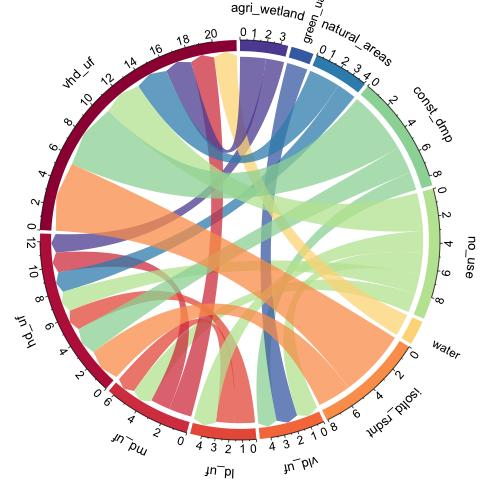

In [107]:
%%R -i plot_emp_rich_coact,n_rich,city
prep_links_df=plot_emp_rich_coact
nb=n_rich
# Libraries

#library(patchwork)
library(hrbrthemes)
library(circlize)
library(chorddiag)  #devtools::install_github("mattflor/chorddiag")
library("ggplot2")
library("ggsci")
# Libraries
library(tidyverse)
library(viridis)
library(RColorBrewer)

# Load dataset from github
# parameters
circos.clear()
circos.par(start.degree = 90,
           track.margin = c(-0.1, 0.1), points.overflow.warning = FALSE)
par(mar = rep(0, 4))
ord <-c('agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
       'motorways',"port",'water',"op_sp_beach",  
       'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf')
# Base plot
chordDiagram(
  x = prep_links_df, 
  transparency = 0.25,
  directional = 1,
  order = c('agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
       'motorways',"port",'water',"op_sp_beach",  
       'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf'),
  grid.col = rev(colorRampPalette(brewer.pal(name="Spectral", n = 11))(nb)),
  annotationTrackHeight = c(0.05, 0.2),
  annotationTrack ="grid",
  link.sort = TRUE, 
  direction.type = c("arrows", "diffHeight"), 
  link.arr.type = "big.arrow", 
  link.largest.ontop = TRUE)



# Add text and axis
circos.trackPlotRegion(
  track.index = 1, 
  bg.border = NA, 
  panel.fun = function(x, y) {
    xlim = get.cell.meta.data("xlim")
    ylim = get.cell.meta.data("ylim")
    sector.index = get.cell.meta.data("sector.index")
    if(abs(CELL_META$cell.start.degree - CELL_META$cell.end.degree) > 10) {
    # Add names to the sector. 
    circos.text(
      x = mean(xlim), 
      y=4,
      facing = "bending",
      labels = sector.index, 
      cex = 1.1,
      )
            # Add graduation on axis
    circos.axis(
      h = "top", 
      major.at = seq(from = 0, to = xlim[2], by = ifelse(test = xlim[2]>6, yes = 2, no = 1)), 
      minor.ticks = 1, 
      major.tick.percentage = 1,
      labels.niceFacing = TRUE)
    }
    else {    # Add names to the sector. 
    circos.text(
      x = mean(xlim), 
      y =4,
      facing = "clockwise",
      labels = sector.index, 
      cex = 1,
      )
    }

    
  }

)
circos.info()



# Add text and axis

In [294]:
plot_emp_rich_coact,n_rich = prepare_plot_emp(prep_emp_rich_coact_lille,20)

In [75]:
test=['agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
       'motorways',"port",'water',"op_sp_beach",  
       'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf']
for k in set(test)-set(plot_emp_rich_coact.neighbour).union(set(plot_emp_rich_coact.object)):
    plot_emp_rich_coact=plot_emp_rich_coact.append(pd.DataFrame([(k,"ld_uf",1e-1)],columns=["neighbour","object","med"]))
n_rich=len(test)
plot_emp_rich_coact.reset_index(drop=True,inplace=True)

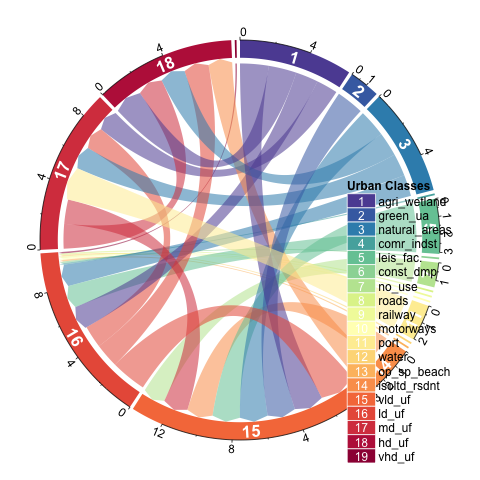

In [76]:
%%R -i plot_emp_rich_coact,n_rich,city
prep_links_df=plot_emp_rich_coact
nb=n_rich
# Libraries

#library(patchwork)
library(hrbrthemes)
library(circlize)
library(chorddiag)  #devtools::install_github("mattflor/chorddiag")
library("ggplot2")
library("ggsci")
# Libraries
library(tidyverse)
library(viridis)
library(RColorBrewer)

# Load dataset from github
# parameters
circos.clear()
circos.par(start.degree = 90,
           track.margin = c(-0.1, 0.1), points.overflow.warning = FALSE)
par(mar = rep(0, 4))
ord <-c('agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
        'motorways',"port",'water',"op_sp_beach",  
        'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf')

col_ord<-rev(colorRampPalette(brewer.pal(name="Spectral", n = 11))(length(ord)))
names(col_ord) <- ord


empty<-plot_emp_rich_coact[plot_emp_rich_coact$med == 0.1,]$neighbour
for (sector in ord){
    if (sector %in% empty){
        col_ord[sector]="#00000000"
    }else{
        col_ord[sector]=paste(col_ord[sector],"CC",sep="")
    }
    
}
# Base plot

chordDiagram(
  x = prep_links_df, 
  transparency = 0.45,
  directional = 1,
  order = ord,
  grid.col = array(col_ord),
  annotationTrackHeight = c(0.08, 1),
  annotationTrack ="grid",
  link.sort = TRUE, 
  direction.type = c("arrows", "diffHeight"), 
  link.arr.type = "big.arrow", 
  link.largest.ontop = TRUE)


# Add text and axis
circos.trackPlotRegion(
  track.index = 1, 
  bg.border = NA, 
  panel.fun = function(x, y) {
    xlim = get.cell.meta.data("xlim")
    ylim = get.cell.meta.data("ylim")
    sector.index = get.cell.meta.data("sector.index")
    sn = CELL_META$sector.numeric.index
    i_state = as.numeric(gsub("(C|R)_", "", sn))
    if(abs(CELL_META$cell.start.degree - CELL_META$cell.end.degree) > 1) {
        circos.text(CELL_META$xcenter, CELL_META$ycenter, sn, col = "white", 
                    font = 2, cex = 1.4, adj = c(0.5, 0.5), niceFacing = TRUE)
        circos.axis(
          h = "top", 
          major.at = seq(from = 0, to = xlim[2], by = ifelse(test = xlim[2]>4, yes = 4, no = 1)), 
          minor.ticks = 1, 
          major.tick.percentage = 1,
          labels.niceFacing = TRUE)
     } 
}
)

# Add text and axis
# Add text and axis
library(grid)
library(gridBase)
library(ComplexHeatmap)
lgd_list_vertical = Legend(at = 1:nb, labels_gp = gpar(fontsize = 12), labels = ord, pch = as.character(1:nb),
         legend_gp = gpar(col = "white", fontsize = 12),title_gp = gpar(fontsize = 12, fontface = "bold"),
                           background = col_ord, type = "points", 
         title = "Urban Classes", grid_width = unit(1, "cm"),grid_height = unit(5, "mm"))

draw(lgd_list_vertical, x = unit(1, "npc") - unit(1, "cm"), y = unit(6, "mm"), 
    just = c("right", "bottom"))



In [73]:
plot_emp_rich_coact,n_rich = prepare_plot_emp(prep_emp_rich_coact,20)

In [316]:
%%R
library(hrbrthemes)
library(circlize)
library(chorddiag)  #devtools::install_github("mattflor/chorddiag")
library("ggplot2")
library("ggsci")
# Libraries
library(tidyverse)
library(viridis)
library(RColorBrewer)

rev(colorRampPalette(brewer.pal(name="Spectral", n = 11))(11))

col_ord<-rev(colorRampPalette(brewer.pal(name="Spectral", n = 11))(2*nb)[2:(nb+1)])


 [1] "#5E4FA2" "#3288BD" "#66C2A5" "#ABDDA4" "#E6F598" "#FFFFBF" "#FEE08B"
 [8] "#FDAE61" "#F46D43" "#D53E4F" "#9E0142"


R[write to console]: ========================================
ComplexHeatmap version 2.1.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.




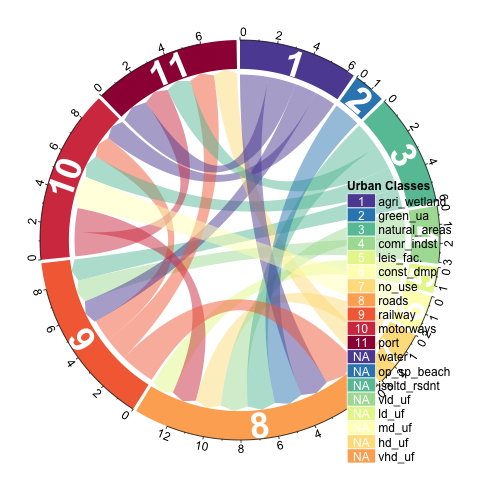

In [74]:
%%R -i plot_emp_rich_coact,n_rich,city
prep_links_df=plot_emp_rich_coact
nb=n_rich
# Libraries

#library(patchwork)
library(hrbrthemes)
library(circlize)
library(chorddiag)  #devtools::install_github("mattflor/chorddiag")
library("ggplot2")
library("ggsci")
# Libraries
library(tidyverse)
library(viridis)
library(RColorBrewer)

# Load dataset from github
# parameters
circos.clear()
circos.par(start.degree = 90,
           track.margin = c(-0.1, 0.1), points.overflow.warning = FALSE)
par(mar = rep(0, 4))
ord <-c('agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
        'motorways',"port",'water',"op_sp_beach",  
        'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf')

col_ord<-rev(colorRampPalette(brewer.pal(name="Spectral", n = 11))(nb))
#names(col_ord) <- ord


chordDiagram(
  x = prep_links_df, 
  transparency = 0.5,
  directional = 1,
  order = ord,
  grid.col = array(col_ord),
  annotationTrackHeight = c(0.13, 1),
  annotationTrack ="grid",
  link.sort = TRUE, 
  direction.type = c("arrows", "diffHeight"), 
  link.arr.type = "big.arrow", 
  link.largest.ontop = TRUE)


# Add text and axis
circos.trackPlotRegion(
  track.index = 1, 
  bg.border = NA, 
  panel.fun = function(x, y) {
    xlim = get.cell.meta.data("xlim")
    ylim = get.cell.meta.data("ylim")
    sector.index = get.cell.meta.data("sector.index")
    sn = CELL_META$sector.numeric.index
    i_state = as.numeric(gsub("(C|R)_", "", sn))
    if(abs(CELL_META$cell.start.degree - CELL_META$cell.end.degree) > 1) {
        circos.text(CELL_META$xcenter, CELL_META$ycenter, sn, col = "white", 
                    font = 2, cex = 3, adj = c(0.5, 0.5), niceFacing = TRUE)
        circos.axis(
          h = "top", 
          major.at = seq(from = 0, to = xlim[2], by = ifelse(test = xlim[2]>6, yes = 2, no = 1)), 
          minor.ticks = 1, 
          major.tick.percentage = 1,
          labels.niceFacing = TRUE)
     } 
}
)

# Add text and axis
library(grid)
library(gridBase)
library(ComplexHeatmap)
lgd_list_vertical = Legend(at = 1:nb, labels_gp = gpar(fontsize = 12), labels = ord, pch = as.character(1:nb),
         legend_gp = gpar(col = "white", fontsize = 12),title_gp = gpar(fontsize = 12, fontface = "bold"),
                           background = col_ord, type = "points", 
         title = "Urban Classes", grid_width = unit(1, "cm"),grid_height = unit(5, "mm"))

draw(lgd_list_vertical, x = unit(1, "npc") - unit(1, "cm"), y = unit(6, "mm"), 
    just = c("right", "bottom"))



In [97]:
plot_emp_rich_coact,n_rich = prepare_plot_emp(prep_emp_rich_coact_lille,20)
ord_class = ['agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
        'motorways',"port",'water',"op_sp_beach",  
        'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf']
ord_class={k:(i+1) for i,k in enumerate(ord_class)}
ord_fun = lambda x:ord_class[x]

In [258]:
final_plot_emp_rich_coact = plot_emp_rich_coact.copy()

In [ ]:
final_plot_emp_rich_coact["neighbour"] = list(map(ord_fun,final_plot_emp_rich_coact["neighbour"]))
final_plot_emp_rich_coact["object"] = list(map(ord_fun,final_plot_emp_rich_coact["object"]))

In [ ]:
%%R -i final_plot_emp_rich_coact,n_rich,city
prep_links_df=final_plot_emp_rich_coact
nb=n_rich
# Libraries

#library(patchwork)
library(hrbrthemes)
library(circlize)
library(chorddiag)  #devtools::install_github("mattflor/chorddiag")
library("ggplot2")
library("ggsci")
# Libraries
library(tidyverse)
library(viridis)
library(RColorBrewer)

# Load dataset from github
# parameters
circos.clear()
circos.par(start.degree = 90,
           track.margin = c(-0.1, 0.1), points.overflow.warning = FALSE)
par(mar = rep(0, 4))
ord <-c('agri_wetland','green_ua','natural_areas','comr_indst','leis_fac.','const_dmp','no_use', 'roads', 'railway',
        'motorways',"port",'water',"op_sp_beach",  
        'isoltd_rsdnt', 'vld_uf', 'ld_uf', 'md_uf', 'hd_uf', 'vhd_uf')
ord<-1:length(ord)
col_ord<-rev(colorRampPalette(brewer.pal(name="Spectral", n = 11)[1:11])(nb))
#names(col_ord) <- ord


chordDiagram(
  x = prep_links_df, 
  transparency = 0.25,
  directional = 1,
  order = ord,
  grid.col = array(col_ord),
  annotationTrackHeight = c(0.08, 1),
  annotationTrack ="grid",
  link.sort = TRUE, 
  direction.type = c("arrows", "diffHeight"), 
  link.arr.type = "big.arrow", 
  link.largest.ontop = TRUE)


# Add text and axis
circos.trackPlotRegion(
  track.index = 1, 
  bg.border = NA, 
  panel.fun = function(x, y) {
    xlim = get.cell.meta.data("xlim")
    ylim = get.cell.meta.data("ylim")
    sector.index = get.cell.meta.data("sector.index")
    sn = CELL_META$sector.numeric.index
    i_state = as.numeric(gsub("(C|R)_", "", sn))
    if(abs(CELL_META$cell.start.degree - CELL_META$cell.end.degree) > 1) {
        #circos.text(CELL_META$xcenter, CELL_META$ycenter, paste("",sector.index,sep=""), col = "black", 
        #            font = 1.5, cex = 1.4, adj = c(0.5, 0.5), niceFacing = TRUE)
        circos.text(CELL_META$xcenter, CELL_META$ycenter, paste("",sector.index,sep=""), col = "white", 
                    font = 2, cex = 1.4, adj = c(0.5, 0.5), niceFacing = TRUE)
        circos.axis(
          h = "top", 
          major.at = seq(from = 0, to = xlim[2], by = ifelse(test = xlim[2]>4, yes = 2, no = 1)), 
          minor.ticks = 1, 
          major.tick.percentage = 1,
          labels.niceFacing = TRUE)
     } 
}
)

# Add text and axis
#library(grid)
#library(gridBase)
#library(ComplexHeatmap)
#lgd_list_vertical = Legend(at = 1:nb, labels_gp = gpar(fontsize = 12), labels = ord, pch = as.character(1:nb),
#         legend_gp = gpar(col = "white", fontsize = 12),title_gp = gpar(fontsize = 12, fontface = "bold"),
#                           background = col_ord, type = "points", 
#         title = "Urban Classes", grid_width = unit(1, "cm"),grid_height = unit(5, "mm"))
#
#draw(lgd_list_vertical, x = unit(1, "npc") - unit(1, "cm"), y = unit(6, "mm"), 
#    just = c("right", "bottom"))



In [ ]:
circle_size = unit(2, "snpc") # snpc unit gives you a square region

pushViewport(viewport(x = 0, y = 1, width = ComplexHeatmap:::width(lgd_list_vertical), 
                      height = ComplexHeatmap:::height(lgd_list_vertical), just = c("right", "center")))
